In [1]:
########### Preparation ##############
# import packages
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import des données
On crée un dataframe Egos qui contient non seulement les informations sur les egos mais aussi leur réseau personnel (egoNet) avec les données des alters.

In [2]:
Egos = pd.read_csv('../data/ego_data.csv', sep = ",")
order_age_cat = ['18-25', '26-30', '31-35','36-40', '41-50', '51-60', '60+']
Egos['ego.age.cat'] = pd.Categorical(Egos['ego.age.cat'], 
                                     categories=order_age_cat, ordered=True)
order_edu_cat = ['Primary', 'Secondary', 'University']
Egos['ego.edu'] = pd.Categorical(Egos['ego.edu'], 
                                     categories=order_edu_cat, ordered=True)
Egos['ego.employed'] = Egos['ego.empl.bin']=="Yes"
Alters = pd.read_csv('../data/alter_attributes.csv', sep = ",")
AltersEdglist = pd.read_table('../data/alter_ties.csv', sep = ",")

def CreatingEgoNet(ego_ID):
    egoNet = nx.from_pandas_edgelist(AltersEdglist[AltersEdglist["ego_ID"]==ego_ID], 'from','to', create_using=nx.Graph())
    nodeData = Alters[Alters["ego_ID"]==ego_ID].set_index('alter_ID').to_dict('index').items()
    egoNet.add_nodes_from(nodeData)
    return egoNet
Egos["egoNet"] = Egos["ego_ID"].apply(CreatingEgoNet)
Egos.set_index("ego_ID", inplace=True)

# adding years since arrival variable
reference_year = 2018 # year of Vacca's publication
Egos["ego.years_since_arr"] = reference_year - Egos["ego.arr"]

Egos.sample(5)

ego.sex  ego.age  ego.arr     ego.edu  ego.inc  empl ego.empl.bin  \
ego_ID                                                                     
120       Male     53.0   2000.0  University    900.0     1           No   
88        Male     31.0   2011.0     Primary    200.0     2           No   
81        Male     30.0   2000.0     Primary    800.0     4          Yes   
125       Male     49.0   2011.0     Primary      0.0     1           No   
56        Male     42.0   1992.0     Primary   1100.0     4          Yes   

       ego.age.cat  ego.employed  \
ego_ID                             
120          51-60         False   
88           31-35         False   
81           26-30          True   
125          41-50         False   
56           41-50          True   

                                                   egoNet  
ego_ID                                                     
120     (12001, 12002, 12003, 12004, 12005, 12006, 120...  
88      (8801, 8802, 8803, 8804, 8805, 8806, 8807, 880...  
81      (8101, 8102, 8103, 8104, 8105, 8106, 8107, 810...  
125     (12501, 12502, 12503, 12504, 12505, 12506, 125...  
56      (5601, 5602, 5603, 5604, 5605, 5606, 5607, 560...

On peut facilement visualiser le réseau de n'importe quel ego de cette façon

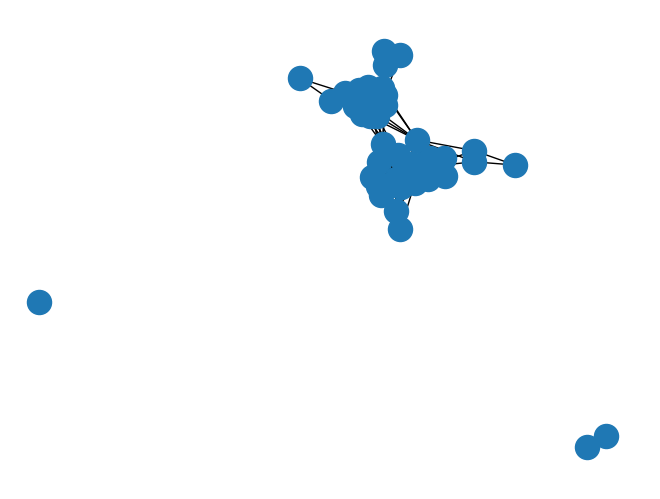

In [3]:
nx.draw(Egos.loc[149,"egoNet"])

# Quelques statistiques structurelles sur les réseaux ego

In [4]:
import networkx as nx
import numpy as np

def calculate_network_metrics(df, egoNet_name):
    """
    Calculate various network metrics for each network in the specified column of a DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the network data.
        egoNet_name (str): The name of the column containing the network data.

    Returns:
        None. Modifies the DataFrame in place by adding columns with calculated metrics.
    """
    # presence of the network
    df[egoNet_name + ".is_empty"] = df[egoNet_name].apply(nx.is_empty)

    # ---- Mean local structures
    # Function to calculate the number of isolates
    nb_isolates = lambda net: len(list(nx.isolates(net))) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".nb_isolates"] = df[egoNet_name].apply(nb_isolates)

    # Triads
    # Function to calculate transitivity
    transitivity = lambda net: nx.transitivity(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".transitivity"] = df[egoNet_name].apply(transitivity)

    # Function to calculate average clustering
    avg_clustering = lambda net: nx.average_clustering(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".average_clustering"] = df[egoNet_name].apply(avg_clustering)

    # ---- Global structures : cohesion
    # Function to calculate density
    density = lambda net: nx.density(net) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".density"] = df[egoNet_name].apply(density)

    # ---- Global structures : connectivity -> not for undirected networks

    # ---- Global structures : centrality
    # Function to calculate mean degree centrality
    mean_degree_centrality = lambda net: np.mean(list(nx.degree_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_degree_centrality"] = df[egoNet_name].apply(mean_degree_centrality)

    # Function to calculate mean eigenvector centrality
    # mean_eigenvector_centrality = lambda net: np.mean(list(nx.eigenvector_centrality(net).values()))
    # df[egoNet_name + ".mean_eigenvector_centrality"] = df[egoNet_name].apply(mean_eigenvector_centrality)

    # Function to calculate mean betweenness centrality
    mean_betweenness_centrality = lambda net: np.mean(list(nx.betweenness_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_betweenness_centrality"] = df[egoNet_name].apply(mean_betweenness_centrality)

    # Function to calculate mean closeness centrality
    mean_closeness_centrality = lambda net: np.mean(list(nx.closeness_centrality(net).values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_closeness_centrality"] = df[egoNet_name].apply(mean_closeness_centrality)


# Usage:
calculate_network_metrics(Egos, "egoNet")


In [5]:
def compute_attributes(df, egoNet_name):
    """
    Calculate various network aggregated attributes for each network.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the network data.
        egoNet_name (str): The name of the column containing the network data.

    Returns:
        None. Modifies the DataFrame in place by adding columns with calculated metrics.
    """

    # number nodes
    nb_nodes = lambda net: nx.number_of_nodes(net) if not nx.is_empty(net) else 0
    df[egoNet_name + ".nb_nodes"] = df[egoNet_name].apply(nb_nodes) 

    # ratio of men in the network
    ratio_men = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.sex").values()))=="Male") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_men"] = df[egoNet_name].apply(ratio_men)

    # ratio of women in the network
    ratio_women = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.sex").values()))=="Female") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_women"] = df[egoNet_name].apply(ratio_women)

    # ratio of close family
    ratio_close_family = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Close family") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_close_family"] = df[egoNet_name].apply(ratio_close_family)

    # ratio of other family
    ratio_other_family = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Other family") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_other_family"] = df[egoNet_name].apply(ratio_other_family)
    
    # ratio of friends
    ratio_friends = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Friends") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_friends"] = df[egoNet_name].apply(ratio_friends)

    # ratio of acquaintances
    ratio_acquaintances = lambda net: np.mean(np.array(list(nx.get_node_attributes(net,"alter.rel").values()))=="Acquaintances") if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".ratio_acquaintances"] = df[egoNet_name].apply(ratio_acquaintances)

    # mean age of the network
    mean_age = lambda net: np.mean(list(nx.get_node_attributes(net,'alter.age').values())) if not nx.is_empty(net) else np.nan
    df[egoNet_name + ".mean_age"] = df[egoNet_name].apply(mean_age)

    # ratio of men in the networks


# Usage:
compute_attributes(Egos, "egoNet")

## Statistiques croisées des métriques réseau Ego avec les variables des Egos

<Axes: xlabel='ego.years_since_arr', ylabel='egoNet.mean_degree_centrality'>

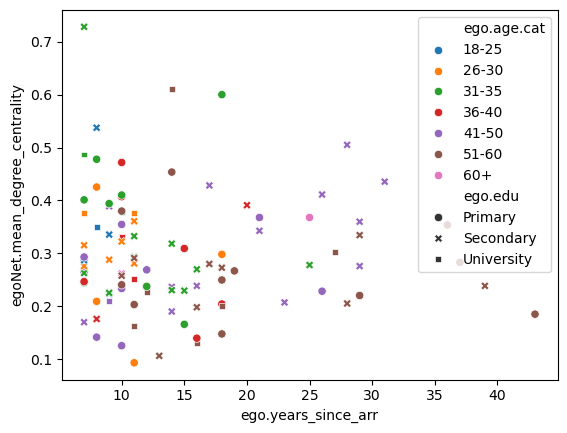

In [6]:
reference_year = 2018 # year of Vacca's publication
Egos["ego.years_since_arr"] = reference_year - Egos["ego.arr"]

sns.scatterplot(data = Egos, x = "ego.years_since_arr", y = "egoNet.mean_degree_centrality", 
                hue= "ego.age.cat",hue_order=order_age_cat,
                style="ego.edu", style_order=order_edu_cat)

<Axes: xlabel='ego.inc', ylabel='egoNet.mean_degree_centrality'>

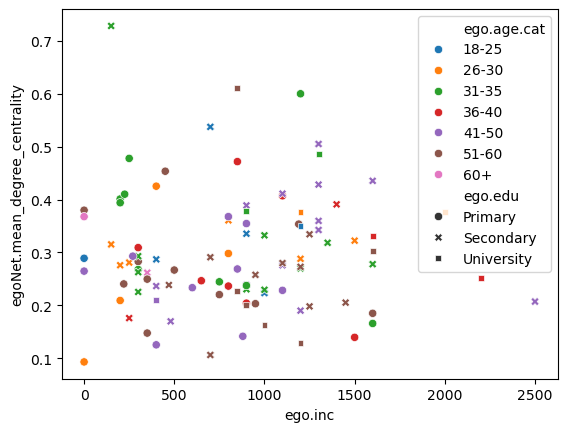

In [7]:
sns.scatterplot(data = Egos, x = "ego.inc", y = "egoNet.mean_degree_centrality", 
                hue= "ego.age.cat",hue_order=order_age_cat,
                style="ego.edu", style_order=order_edu_cat)

<Axes: xlabel='ego.age.cat', ylabel='egoNet.mean_degree_centrality'>

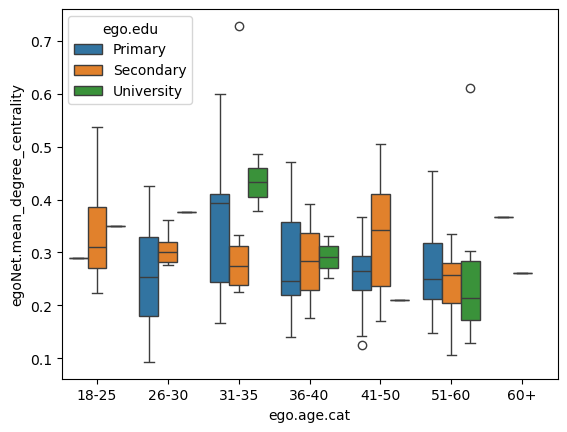

In [8]:
sns.boxplot(data=Egos, x="ego.age.cat", y="egoNet.mean_degree_centrality", hue="ego.edu")

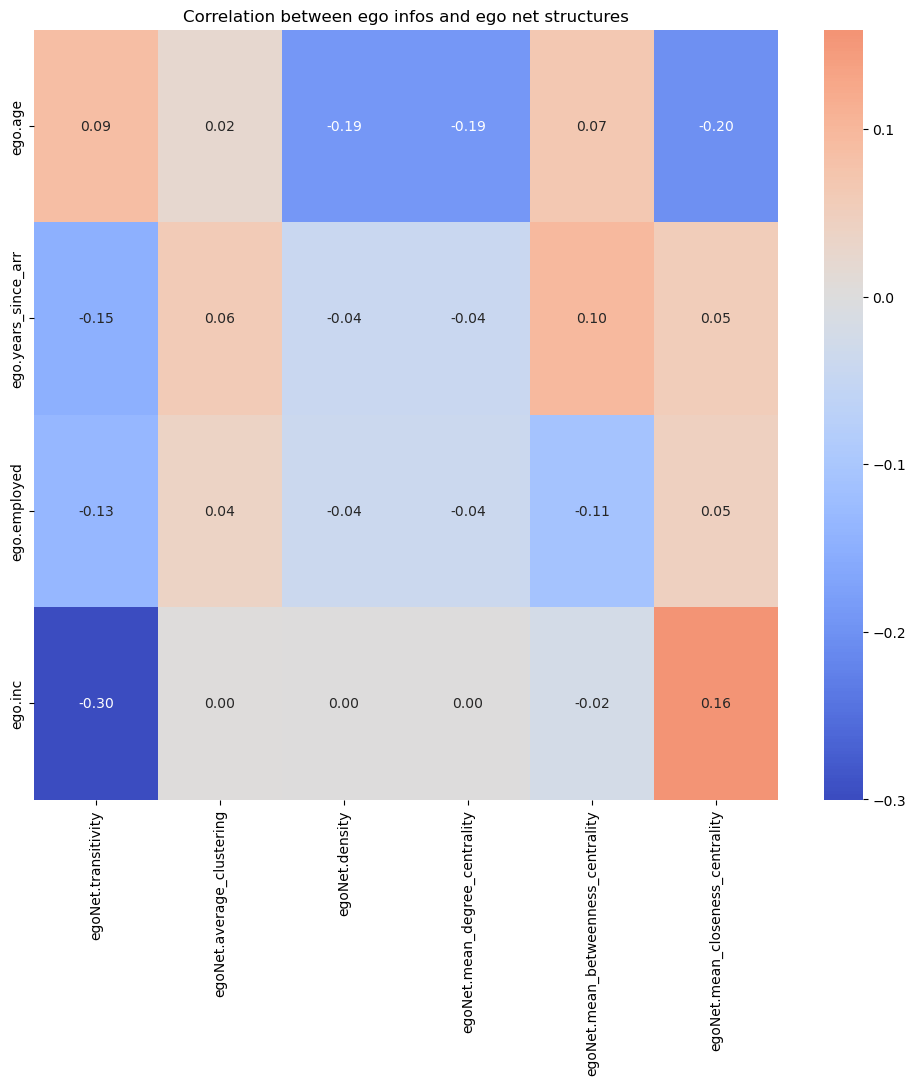

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named Egos
# Replace Egos with the name of your dataframe

# Define variables for each group
group1_vars = ['ego.age','ego.years_since_arr','ego.employed', 'ego.inc']
group2_vars = ['egoNet.transitivity', 'egoNet.average_clustering', 'egoNet.density',
               'egoNet.mean_degree_centrality',
               'egoNet.mean_betweenness_centrality',
               'egoNet.mean_closeness_centrality']

# Calculate correlation matrix between the two groups
corr = Egos[group1_vars + group2_vars].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(corr.loc[group1_vars, group2_vars], cmap='coolwarm', annot=True, fmt=".2f", center=0)

plt.title('Correlation between ego infos and ego net structures')
plt.show()


# Découpe du Ego Net en sous réseau selon l'origine de l'Alter

## Exemple sur  l'Ego 28 et définitions de fonctions

In [6]:
egoNet28  = Egos.loc[28,"egoNet"]

In [7]:
import networkx as nx

def filter_graph_by_attribute(graph, attribute_name, desired_category, keep_true=True):
    """
    Filter a NetworkX graph based on a categorical attribute and retain node attributes.
    
    Parameters:
        graph (nx.Graph): The original NetworkX graph.
        attribute_name (str): The name of the categorical attribute to filter on.
        desired_category (str): The desired category value.
        keep_true (bool): If True, keep nodes where the attribute matches the desired category.
                          If False, keep nodes where the attribute does not match the desired category.
    
    Returns:
        nx.Graph: The filtered graph.
    """
    filtered_graph = nx.Graph()
    
    try:
        # Add nodes from the original graph based on the value of the categorical attribute
        for n, data in graph.nodes(data=True):
            if (keep_true and data.get(attribute_name) == desired_category) or (not keep_true and data.get(attribute_name) != desired_category):
                filtered_graph.add_node(n, **data)
        
        # Add edges from the original graph involving the filtered nodes
        for u, v, data in graph.edges(data=True):
            if u in filtered_graph and v in filtered_graph:  # Ensure both nodes are in the filtered graph
                filtered_graph.add_edge(u, v, **data)
        
    except Exception as e:
        print("An error occurred while filtering the graph:", e)
    
    return filtered_graph

# Example usage:
# Assuming G is your original graph
# filtered_G = filter_graph_by_attribute(G, 'category_attribute', 'desired_category_value', keep_true=True)

Réseau personnel de l'ego 28 au Sri Lanka

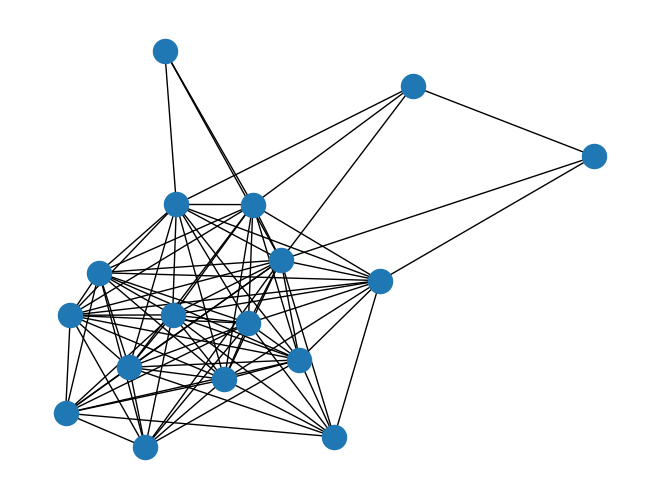

In [8]:
filter_resSL_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Sri Lanka", keep_true=True)
nx.draw(filter_resSL_natSL(egoNet28))

Réseau personnel de l'ego 28 de Srilankais habitants en Italie

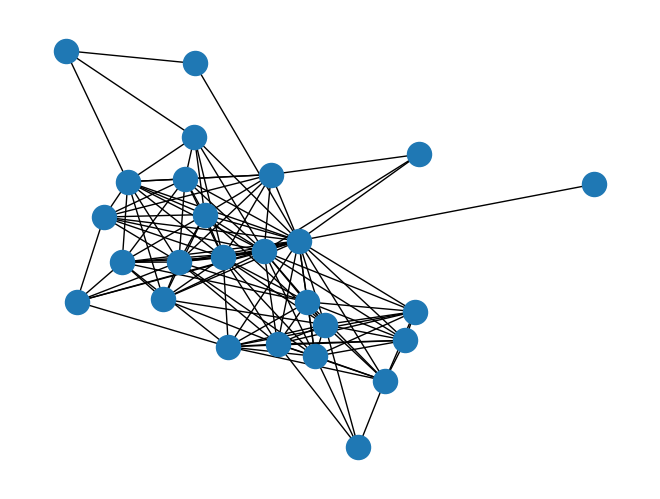

In [9]:
filter_resHorsSL_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Sri Lanka", keep_true=False)
nx.draw(filter_resHorsSL_natSL(egoNet28))

Réseau personnel de l'ego 28 de Srilankais habitant en Italie

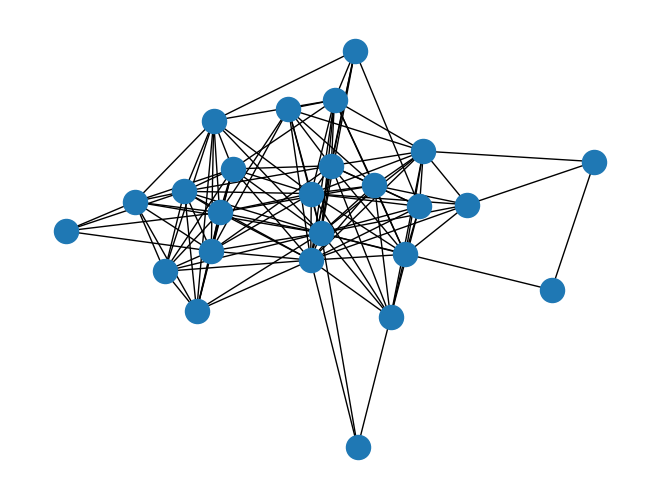

In [14]:
filter_resIT_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natSL(egoNet28))

Réseau personnel de l'ego 28 en Italie non srilankais

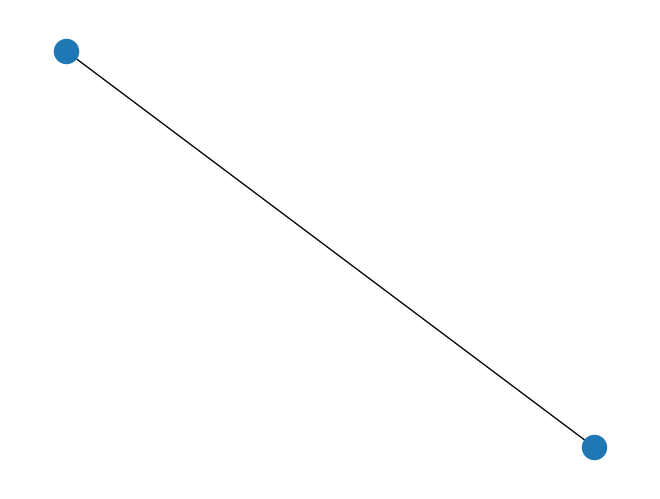

In [10]:
filter_resIT_natNonSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=False),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natNonSL(egoNet28))

Réseau personnel de l'ego 28 de nationalité italienne

In [11]:
filter_natIT = lambda net: filter_graph_by_attribute(net, 
                                'alter.nat', "Italy", keep_true=True)
nx.is_empty(filter_natIT(egoNet28))

True

## Sous réseaux du réseau Ego selon la nationalité et la résidence

In [12]:
Egos['resSL_natSL_egoNet'] = Egos['egoNet'].apply(filter_resSL_natSL)
Egos['resIT_natSL_egoNet'] = Egos['egoNet'].apply(filter_resIT_natSL)
Egos['resIT_natNonSL_egoNet'] = Egos['egoNet'].apply(filter_resIT_natNonSL)
Egos['natIT_egoNet'] = Egos['egoNet'].apply(filter_natIT)

In [13]:
calculate_network_metrics(Egos, 'resSL_natSL_egoNet')
calculate_network_metrics(Egos, 'resIT_natSL_egoNet')
calculate_network_metrics(Egos, 'resIT_natNonSL_egoNet')
calculate_network_metrics(Egos, 'natIT_egoNet')

### Présence d'un réseau Sri Lankais au Sri Lanka

In [14]:
Egos['resSL_natSL_egoNet.is_empty'].value_counts()

False    102
Name: resSL_natSL_egoNet.is_empty, dtype: int64

### Présence d'un réseau Sri Lankais en Italie

In [15]:
Egos['resIT_natSL_egoNet.is_empty'].value_counts()

resITnatSL_egoNet.is_empty
False    102
Name: resIT_natSL_egoNet.is_empty, dtype: int64

### Présence d'un réseau en Italie, non srilankais

In [16]:
Egos['resIT_natNonSL_egoNet.is_empty'].value_counts()

False    90
True     12
Name: resIT_natNonSL_egoNet.is_empty, dtype: int64

<AxesSubplot: xlabel='resIT_natNonSL_egoNet.is_empty', ylabel='ego.age'>

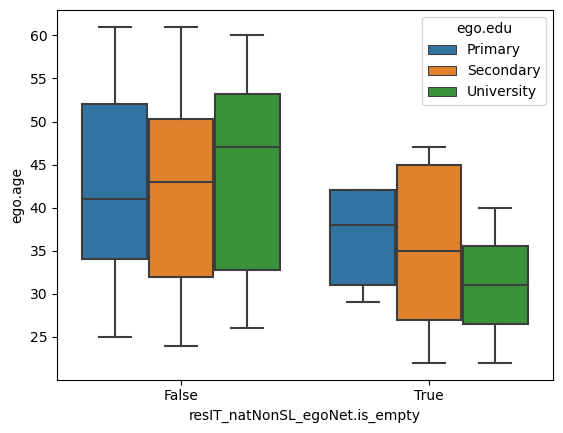

In [17]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.age", hue="ego.edu")

<AxesSubplot: xlabel='resIT_natNonSL_egoNet.is_empty', ylabel='ego.years_since_arr'>

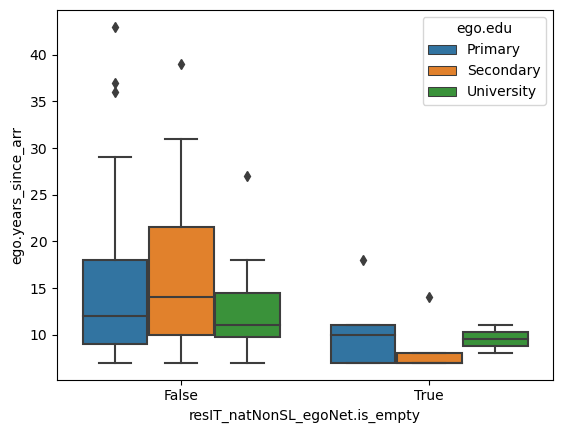

In [18]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.years_since_arr", hue="ego.edu")

<AxesSubplot: xlabel='resIT_natNonSL_egoNet.is_empty', ylabel='ego.inc'>

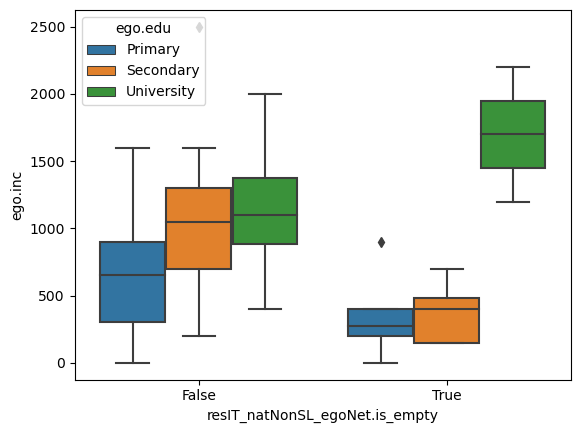

In [19]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="ego.inc", hue="ego.edu")

<AxesSubplot: xlabel='resIT_natNonSL_egoNet.is_empty', ylabel='empl'>

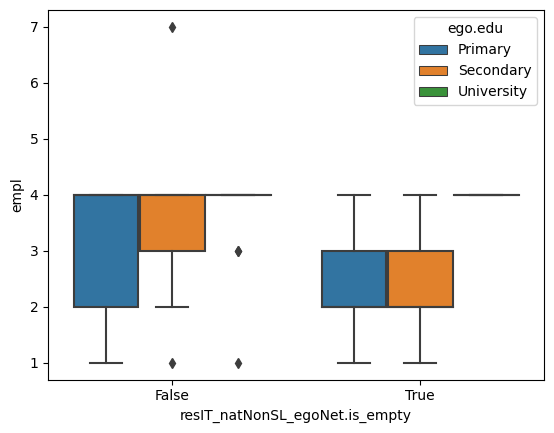

In [20]:
sns.boxplot(data=Egos, x='resIT_natNonSL_egoNet.is_empty', y="empl", hue="ego.edu")

### Présence d'un réseau composé d'italiens

In [21]:
Egos['natIT_egoNet.is_empty'].value_counts()

natIT_egoNet.is_empty
False    69
True     33
Name: count, dtype: int64

# Comparaison réseau Sri Lankais au Sri Lanka et Sri Lankais en Italie

In [22]:
compute_attributes(Egos, 'resIT_natSL_egoNet')
compute_attributes(Egos, 'resIT_natNonSL_egoNet')

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir les variables à comparer
attributes_to_compare = ['ratio_men', 'ratio_close_family', 'ratio_other_family', 'ratio_friends','mean_age']

# Définir les réseaux à comparer
networks_to_compare = ['resIT_natSL_egoNet', 'resIT_natNonSL_egoNet']

# Covariables pour comparaison
covariates_to_compare = ['ego.age.cat','ego.edu']

# Filtrer le DataFrame pour inclure uniquement les colonnes correspondant aux attributs à comparer et aux réseaux à comparer
filtered_df = Egos[[f"{network}.{attribute}" for network in networks_to_compare for attribute in attributes_to_compare]]

# Renommer les colonnes en fonction du type de réseau
filtered_df.columns = pd.MultiIndex.from_tuples([(attribute.split('.')[1], attribute.split('.')[0]) for attribute in filtered_df.columns], names=['Attribute', 'Network'])

# Réaliser une opération de pivot où le préfixe devient un type de variable
pivot_df = filtered_df.stack(level='Network').reset_index()

pivot_df = pivot_df.join(Egos[covariates_to_compare], on = "ego_ID",how = "left",validate="many_to_one")

pivot_df.head()


/tmp/ipykernel_16444/135774407.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_df = filtered_df.stack(level='Network').reset_index()


,ego_ID,Network,ratio_men,ratio_close_family,ratio_other_family,ratio_friends,mean_age,ego.age.cat,ego.edu
0,28,resIT_natNonSL_egoNet,46.000000,0.000000,0.500000,0.000000,0.0,60+,Secondary
1,28,resIT_natSL_egoNet,43.160000,0.000000,0.720000,1.000000,0.0,60+,Secondary
2,29,resIT_natSL_egoNet,41.933333,0.033333,0.833333,0.966667,0.0,36-40,Primary
3,33,resIT_natNonSL_egoNet,34.307692,0.000000,0.153846,0.692308,0.0,26-30,Primary
4,33,resIT_natSL_egoNet,39.600000,0.000000,0.800000,0.800000,0.0,26-30,Primary


<Axes: xlabel='ego.edu', ylabel='ratio_men'>

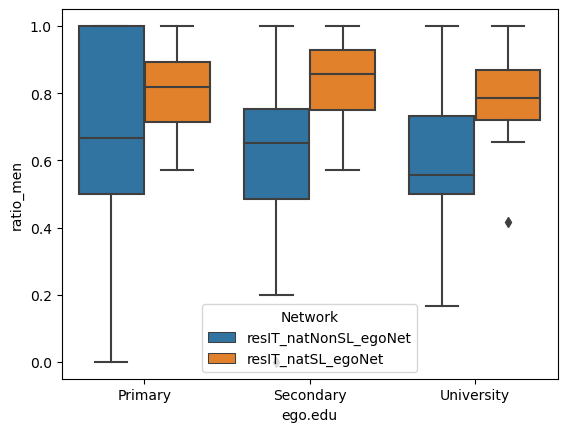

In [24]:
sns.boxplot(data=pivot_df, x='ego.edu', y="ratio_men", hue='Network')

<Axes: xlabel='ego.edu', ylabel='ratio_close_family'>

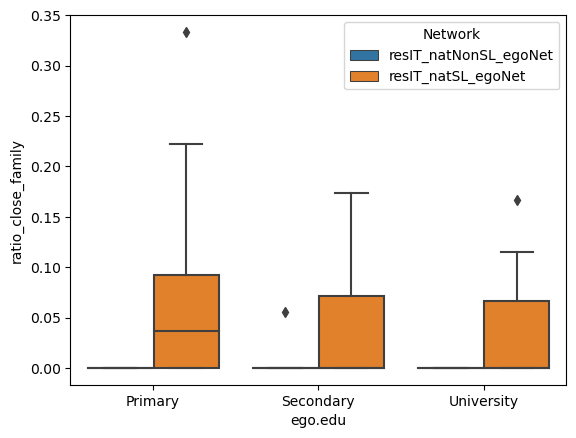

In [25]:
sns.boxplot(data=pivot_df, x='ego.edu', y="ratio_close_family", hue='Network')

<Axes: xlabel='ego.age.cat', ylabel='ratio_other_family'>

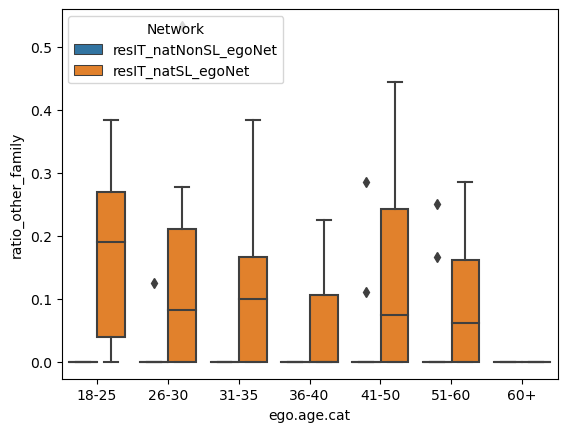

In [26]:
# Créer un box plot avec Seaborn
sns.boxplot(data=pivot_df, x='ego.age.cat', y="ratio_other_family", hue='Network')


<Axes: xlabel='ego.edu', ylabel='ratio_friends'>

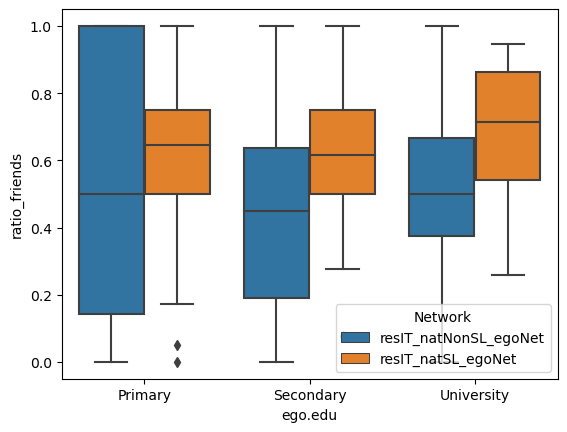

In [27]:
# Créer un box plot avec Seaborn
sns.boxplot(data=pivot_df, x='ego.edu', y="ratio_friends", hue='Network')


<Axes: xlabel='ego.age.cat', ylabel='mean_age'>

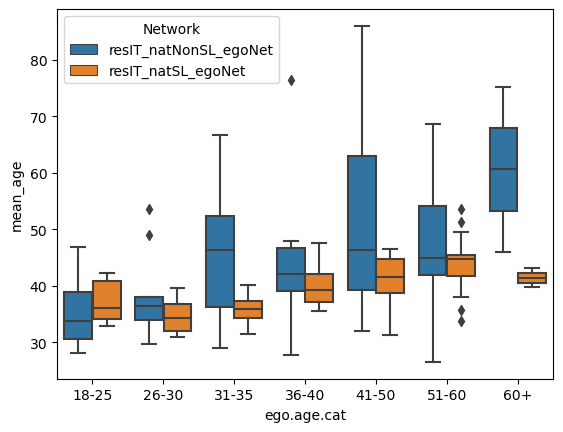

In [28]:
# Créer un box plot avec Seaborn
sns.boxplot(data=pivot_df, x='ego.age.cat', y="mean_age", hue='Network')


## Liens entre les réseaux sri lankais et non sri lankais en Italie